<a href="https://colab.research.google.com/github/ngmitu31/Recomedation_System/blob/main/Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('//content/drive/MyDrive/Movie Recommendation System/dataset')
print("We are currently in the folder of ", os.getcwd())

We are currently in the folder of  /content/drive/MyDrive/Movie Recommendation System/dataset


In [3]:
# https://www.kaggle.com/code/hnaw257/baseline-item-based-and-user-based-cf/notebook

In [6]:
import os
import gc
import random
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from datetime import datetime
from scipy import sparse
from scipy.sparse import csr_matrix
from ipywidgets import interact
from IPython.display import Image

# Surprise Imports
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp

# Scikit-Learn Imports
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Configuration
# matplotlib.use('nbagg')
# plt.rcParams.update({'figure.max_open_warning': 0})
sns.set_style('whitegrid')

In [8]:
credits = pd.read_csv('/content/drive/MyDrive/Movie Recommendation System/dataset/credits.csv')
credits

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862
...,...,...,...
45471,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050
45472,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109
45473,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758
45474,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",227506


In [10]:
movies = pd.read_csv('/content/drive/MyDrive/Movie Recommendation System/dataset/movies_metadata.csv')
movies

<ipython-input-10-5be08684e3b2>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv('/content/drive/MyDrive/Movie Recommendation System/dataset/movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [11]:
ratings = pd.read_csv('/content/drive/MyDrive/Movie Recommendation System/dataset/ratings_small.csv')
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [12]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [13]:
keywords = pd.read_csv('/content/drive/MyDrive/Movie Recommendation System/dataset/keywords.csv')
keywords

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...
46414,439050,"[{'id': 10703, 'name': 'tragic love'}]"
46415,111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46416,67758,[]
46417,227506,[]


# User-based collaborative filtering

In [41]:
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [17]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


## Train-test split

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(ratings, test_size=0.2, random_state=42)

print(f'Train set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

Train set shape: (80003, 4)
Test set shape: (20001, 4)


In [19]:
X_test.head()

,userId,movieId,rating,timestamp
19090,128,1028,5.0,1049690908
99678,665,4736,1.0,1010197684
18455,120,4002,3.0,1167420604
35755,257,1274,4.0,1348544094
66536,468,6440,4.0,1296191715


In [21]:
user_df = X_train.groupby(by='userId').count()['movieId'].to_frame().reset_index()
user_df.head()

,userId,movieId
0,1,19
1,2,68
2,3,38
3,4,170
4,5,80


In [22]:
min_rating_count = np.min(user_df['movieId'])
min_rating_count

12

In [23]:
lowest_rating = X_train.groupby(by='movieId').min()['rating'].to_frame().reset_index()
np.min(lowest_rating['rating'])

0.5

In [25]:
lowest_avg_rating =  X_train.groupby(by='movieId').mean()['rating'].to_frame().reset_index()
np.min(lowest_avg_rating['rating'])

0.5

In [26]:
# pivot ratings into movie features
user_data = X_train.pivot(index = 'userId', columns = 'movieId', values = 'rating').fillna(0)
user_data.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,160656,160718,161084,161155,161594,161830,161918,161944,162542,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create a Copy of train and test dataset
These datasets will be used for prediction and evaluation.

Dummy train will be used later for prediction of the movies which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction.

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [27]:
# make a copy of train and test datasets
dummy_train = X_train.copy()
dummy_test = X_test.copy()

dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x>=1 else 1)
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)

In [28]:
X_train.head()

,userId,movieId,rating,timestamp
37865,273,5816,4.5,1466946328
46342,339,2028,4.5,1446663181
64614,461,3895,0.5,1093224965
41974,300,3578,4.5,1086010878
50236,369,292,3.0,847465462


In [29]:
dummy_train.head()

,userId,movieId,rating,timestamp
37865,273,5816,0,1466946328
46342,339,2028,0,1446663181
64614,461,3895,1,1093224965
41974,300,3578,0,1086010878
50236,369,292,0,847465462


In [30]:
# For dummy train The movie not rated by user is makred as 1 for prediction
dummy_train = dummy_train.pivot(index = 'userId', columns = 'movieId', values = 'rating').fillna(1)

# For dummy test The movies not rated by user is marked as 0 for evaluation
dummy_test = dummy_test.pivot(index ='userId', columns = 'movieId', values = 'rating').fillna(0)

In [31]:
dummy_train.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,160656,160718,161084,161155,161594,161830,161918,161944,162542,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [32]:
dummy_test.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,156607,156609,157667,159462,160440,160563,160567,160590,162376,162672
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## User-User Similarity matrix

### Using Cosine simlarity

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

# User Similarity Matrix using cosine simlarity as similarity measure between users
user_similarity = cosine_similarity(user_data)
user_similarity[np.isnan(user_similarity)] = 0
print(user_similarity)
print(user_similarity.shape)

[[1.         0.         0.         ... 0.07542284 0.         0.02026527]
 [0.         1.         0.09203741 ... 0.02181    0.11202602 0.07466204]
 [0.         0.09203741 1.         ... 0.02550377 0.06519761 0.08121573]
 ...
 [0.07542284 0.02181    0.02550377 ... 1.         0.         0.05777117]
 [0.         0.11202602 0.06519761 ... 0.         1.         0.18560768]
 [0.02026527 0.07466204 0.08121573 ... 0.05777117 0.18560768 1.        ]]
(671, 671)


671 user is calculated similarity with each other

## Predicting the User Ratings on the movies

In [34]:
user_predicted_ratings = np.dot(user_similarity, user_data)
user_predicted_ratings

array([[1.54068397e+01, 6.61076805e+00, 3.53787583e+00, ...,
        1.06313337e-01, 1.22982648e-01, 1.96664936e-01],
       [9.34430163e+01, 6.26741044e+01, 1.95745687e+01, ...,
        1.20408504e-01, 1.18542856e-01, 3.95378725e-01],
       [6.93258590e+01, 2.82110817e+01, 1.02840944e+01, ...,
        3.61203948e-01, 1.90106672e-01, 3.45262604e-01],
       ...,
       [3.41383823e+01, 1.20493471e+01, 7.66671139e+00, ...,
        6.23701001e-02, 0.00000000e+00, 2.69870051e-01],
       [8.24544354e+01, 3.31314700e+01, 1.53520175e+01, ...,
        1.48812863e-01, 2.29527803e-01, 5.19105404e-01],
       [1.36567530e+02, 4.50593308e+01, 1.82092517e+01, ...,
        5.58108300e-01, 4.61045184e-01, 6.54410264e-01]])

In [35]:
user_predicted_ratings.shape

(671, 8399)

We do not want to recommend the same movie that the user already watched. We are interested only in the movies not rated by the user, we will ignore the movies rated by the user.

This is where we will use our dummy train matrix that we previously built.

In [36]:
# np.multiply for cell-by-cell multiplication

user_final_ratings = np.multiply(user_predicted_ratings, dummy_train)
user_final_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,160656,160718,161084,161155,161594,161830,161918,161944,162542,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,15.406840,6.610768,3.537876,0.625677,2.355066,6.096654,3.380348,0.208561,1.062132,6.738645,...,0.137665,0.157332,0.098332,0.023587,0.208659,0.062313,0.093470,0.106313,0.122983,0.196665
2,93.443016,62.674104,19.574569,5.529453,19.471383,45.113065,15.612914,0.889790,6.168715,0.000000,...,0.276765,0.316303,0.197689,0.064014,0.314616,0.113828,0.170741,0.120409,0.118543,0.395379
3,69.325859,28.211082,10.284094,1.871795,11.068821,27.391836,7.536065,0.349686,2.835081,30.429980,...,0.241684,0.276210,0.172631,0.051614,0.355361,0.071557,0.107336,0.361204,0.190107,0.345263
4,98.264009,44.441245,17.981670,3.369811,15.850499,36.396461,15.247535,0.939714,4.801274,43.671391,...,0.400867,0.458133,0.286333,0.093359,0.551087,0.204328,0.306492,0.569463,0.204502,0.572666
5,85.208951,39.827411,13.565881,2.604267,16.706743,29.083798,10.726479,0.797299,2.726907,38.229053,...,0.304012,0.347443,0.217152,0.081578,0.575598,0.139597,0.209396,0.346730,0.439235,0.434304


### Top 5 movie recommendations for User 42

In [37]:
user_final_ratings.iloc[42].sort_values(ascending = False)[0:5]

movieId
296     108.352215
318     107.574203
593     101.654621
260      92.715268
2571     86.822771
Name: 43, dtype: float64

In [38]:
def make_recommendation(user_id, ratings_matrix, no_of_recommendations):
    """Recommends movies to a user based on their ratings.

    Args:
        user_id (int): The ID of the user for whom recommendations are made.
        ratings_matrix (pd.DataFrame): A DataFrame containing user-movie ratings.
        no_of_recommendations (int): The number of movie recommendations to return.
        movies (pd.DataFrame): A DataFrame containing movie information (id and original_title).

    Returns:
        pd.DataFrame: A DataFrame containing the top movie recommendations for the user.
    """

    # Get the user's ratings (assuming ratings_matrix has user IDs as rows)
    user_ratings = ratings_matrix.iloc[user_id].copy().reset_index()
    user_ratings.columns = ['movieId', 'similarity']
    user_ratings['movieId'] = user_ratings['movieId'].astype(str)

    # Sort ratings in descending order (highest-rated first)
    user_ratings.sort_values(by = 'similarity',ascending=False, inplace=True)

    # Select the top 'no_of_recommendations' movies based on ratings
    top_rated_movies = user_ratings.iloc[:no_of_recommendations]

    # Merge user ratings with movie information for efficient selection
    recommended_movies = pd.merge(
        top_rated_movies,
        movies[['id', 'original_title']],
        how='left',
        left_on='movieId',  # Assuming the index in user_ratings is the movie ID
        right_on='id'
    )

    # Select only the recommended movie columns and rename the rating column for clarity
    return recommended_movies

In [39]:
make_recommendation(42, user_final_ratings, 5)

,movieId,similarity,id,original_title
0,296,108.352215,296,Terminator 3: Rise of the Machines
1,318,107.574203,318,The Million Dollar Hotel
2,593,101.654621,593,Солярис
3,260,92.715268,260,The 39 Steps
4,2571,86.822771,NaN,NaN


# Item-based collaborative filtering

In [40]:
movie_features = X_train.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
movie_features

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Item-Item Similarity Matrix

### Using Cosine similarity

In [44]:
from sklearn.metrics.pairwise import cosine_similarity

# Item Similarity Matrix using cosine simlarity as similarity measure between items
item_similarity = cosine_similarity(movie_features)
item_similarity[np.isnan(item_similarity)] = 0
print(item_similarity)

print("- "*10)
print(item_similarity.shape)

[[1.         0.30395395 0.24093218 ... 0.08875662 0.         0.06212963]
 [0.30395395 1.         0.21336273 ... 0.         0.         0.        ]
 [0.24093218 0.21336273 1.         ... 0.         0.         0.        ]
 ...
 [0.08875662 0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.06212963 0.         0.         ... 0.         0.         1.        ]]
- - - - - - - - - - 
(8399, 8399)


## Predicting the User ratings on the movies

In [45]:
item_predicted_ratings = np.dot(movie_features.T, item_similarity)
print(item_predicted_ratings.shape)
item_predicted_ratings

(671, 8399)


array([[  8.68857593,   7.07089891,   5.19723196, ...,   0.68773484,
          0.25940262,   3.2278163 ],
       [ 58.71275326,  64.35464784,  35.52352282, ...,   1.22792698,
          0.21839707,  11.88075247],
       [ 31.9519179 ,  23.4270523 ,  12.95637869, ...,   2.42033159,
          0.45471367,   7.31846444],
       ...,
       [ 17.87201938,  13.36508359,   9.98022217, ...,   0.26383888,
          0.        ,   7.00406038],
       [ 27.0378024 ,  18.70332788,  12.0922367 , ...,   0.76578531,
          0.28485435,   6.98692149],
       [111.56336242,  67.52921456,  39.60714774, ...,   6.32491578,
          1.48017328,  23.7689051 ]])

In [46]:
dummy_train.shape

(671, 8399)

### Filtering the ratings only for the movies not already rated by the user for recommendation

In [47]:
# np.multiply for cell-by-cell multiplication - already rated movies will be removed

item_final_ratings = np.multiply(item_predicted_ratings, dummy_train)
item_final_ratings

movieId,1,2,3,4,5,6,7,8,9,10,...,160656,160718,161084,161155,161594,161830,161918,161944,162542,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,8.688576,7.070899,5.197232,2.157201,4.052747,5.966951,5.658616,1.846296,2.721231,6.617353,...,3.227816,3.227816,3.227816,2.459160,4.648774,3.507185,3.507185,0.687735,0.259403,3.227816
2,58.712753,64.354648,35.523523,24.738538,34.717878,46.690450,36.834883,10.332751,20.804686,0.000000,...,11.880752,11.880752,11.880752,10.795504,10.435684,11.205347,11.205347,1.227927,0.218397,11.880752
3,31.951918,23.427052,12.956379,6.012457,14.396255,22.379477,11.596600,3.731687,6.287688,23.286453,...,7.318464,7.318464,7.318464,6.982945,11.700331,6.008817,6.008817,2.420332,0.454714,7.318464
4,158.570814,134.494418,83.540516,39.029065,80.248546,101.574265,92.875752,29.085033,42.281631,113.942143,...,38.456756,38.456756,38.456756,37.801531,48.057765,49.743441,49.743441,13.611191,0.852317,38.456756
5,82.370422,64.425124,33.719448,15.382457,42.147687,50.537093,33.672895,11.801861,11.095025,59.808936,...,15.594232,15.594232,15.594232,20.614125,29.799913,19.556304,19.556304,4.223790,1.556017,15.594232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,43.479606,39.841372,28.139653,20.299589,24.612779,0.000000,29.345951,7.747513,17.912652,41.120551,...,9.749168,9.749168,9.749168,8.932791,6.899314,7.444649,7.444649,0.599113,0.291196,9.749168
668,15.838493,9.702349,5.970994,3.370385,5.080664,11.613704,5.587371,3.016512,2.164976,9.225229,...,4.167464,4.167464,4.167464,3.879748,3.113682,3.656907,3.656907,0.000000,0.000000,4.167464
669,17.872019,13.365084,9.980222,4.408428,9.539915,11.869786,10.168190,4.911260,6.007526,10.801102,...,7.004060,7.004060,7.004060,6.093432,6.391008,4.364844,4.364844,0.263839,0.000000,7.004060


### Top 5 Movies for User 42

In [48]:
item_final_ratings.iloc[42].sort_values(ascending = False)[0:5]

movieId
2918    65.557241
2797    65.304955
1265    62.948068
2987    62.725464
1097    62.583690
Name: 43, dtype: float64

In [49]:
make_recommendation(42, item_final_ratings, 5)

,movieId,similarity,id,original_title
0,2918,65.557241,NaN,NaN
1,2797,65.304955,NaN,NaN
2,1265,62.948068,1265,Bridge to Terabithia
3,2987,62.725464,NaN,NaN
4,1097,62.583690,NaN,NaN


# Evaluation
Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the User instead of predicting it for the movie not rated by the user.

## Using User-User similarity

In [50]:
test_user_features = X_test.pivot(index = 'userId', columns = 'movieId', values = 'rating').fillna(0)
test_user_similarity = cosine_similarity(test_user_features)
test_user_similarity[np.isnan(test_user_similarity)] = 0

print(test_user_similarity)
print("- "*10)
print(test_user_similarity.shape)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.07052806 ... 0.         0.         0.06730748]
 [0.         0.07052806 1.         ... 0.06539793 0.22632192 0.04852556]
 ...
 [0.         0.         0.06539793 ... 1.         0.1573438  0.        ]
 [0.         0.         0.22632192 ... 0.1573438  1.         0.01751247]
 [0.         0.06730748 0.04852556 ... 0.         0.01751247 1.        ]]
- - - - - - - - - - 
(671, 671)


In [51]:
user_predicted_ratings_test = np.dot(test_user_similarity, test_user_features)
user_predicted_ratings_test

array([[ 0.        ,  0.        ,  0.29270469, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.02392823,  2.10473385,  0.27296967, ...,  0.21407216,
         0.11179926,  0.        ],
       [ 9.98895489,  3.46802363,  0.65303187, ...,  0.25079613,
         0.40838383,  0.        ],
       ...,
       [ 3.41832998,  1.33902987,  0.91733516, ...,  0.        ,
         0.18660078,  0.        ],
       [20.24440588,  2.71931211,  0.73285295, ...,  0.16709584,
         0.29961278,  0.        ],
       [ 5.16390986,  2.57667353,  0.29035348, ...,  0.28307007,
         0.19999581,  0.        ]])

## Testing on the movies already rated by the user

In [53]:
test_user_final_rating = np.multiply(user_predicted_ratings_test, dummy_test)
test_user_final_rating

movieId,1,2,3,4,5,6,7,8,9,10,...,156607,156609,157667,159462,160440,160563,160567,160590,162376,162672
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,10.088229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.0,5.987037,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
ratings['rating'].describe()

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

But we need to normalize the final rating values between range (0.5, 5)

In [55]:
from sklearn.preprocessing import MinMaxScaler

X = test_user_final_rating.copy()
X = X[X > 0] # only consider non-zero values as 0 means the user haven't rated the movies

scaler = MinMaxScaler(feature_range = (0.5, 5))
scaler.fit(X)
pred = scaler.transform(X)

print(pred)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


[[      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 ...
 [      nan       nan       nan ...       nan       nan       nan]
 [2.8012215       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]]


In [56]:
# total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(pred))
total_non_nan

19782

In [57]:
test = X_test.pivot(index = 'userId', columns = 'movieId', values = 'rating')
test

movieId,1,2,3,4,5,6,7,8,9,10,...,156607,156609,157667,159462,160440,160563,160567,160590,162376,162672
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# RMSE Score

diff_sqr_matrix = (test - pred)**2
sum_of_squares_err = diff_sqr_matrix.sum().sum() # df.sum().sum() by default ignores null values

rmse = np.sqrt(sum_of_squares_err/total_non_nan)
print('Baseline User-based CF')
print('='*40)
print("RMSE: ",rmse)

diff_sqr_matrix = (test - pred)**2
abs_diff_matrix = np.abs(test - pred)

# Handle division by zero (choose one approach)
# Option 1 (filter out zeros):
# non_zero_idx = test != 0
# safe_pct_err_matrix = (abs_diff_matrix[non_zero_idx] / test[non_zero_idx]) * 100

# Option 2 (safe division):
safe_pct_err_matrix = np.true_divide(abs_diff_matrix, test) * 100

mape = np.mean(safe_pct_err_matrix)

print("MAPE: ", mape)

mae = np.abs(pred - test).sum().sum()/total_non_nan
print("MAE: ",mae)

print('='*40)

Baseline User-based CF
RMSE:  1.718813661242386
MAPE:  movieId
1         43.202455
2         24.994759
3         34.097993
4         58.333333
5         16.110736
            ...    
160563    87.500000
160567    87.500000
160590    90.000000
162376    88.888889
162672    83.333333
Length: 4901, dtype: float64
MAE:  1.348441382685759


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


It means that on an average our User-based recommendation engine is making an error of 1.3 in predicting the User ratings.

Now, let's evaluate Item-based recommendation engine.

## Using Item-Item Similarity

In [59]:
test_item_features = X_test.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
test_item_similarity = cosine_similarity(test_item_features)
test_item_similarity[np.isnan(test_item_similarity)] = 0

print(test_item_similarity)
print("- "*10)
print(test_item_similarity.shape)

[[1.         0.02332432 0.06892928 ... 0.14540649 0.18175811 0.        ]
 [0.02332432 1.         0.         ... 0.         0.         0.        ]
 [0.06892928 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.14540649 0.         0.         ... 1.         0.         0.        ]
 [0.18175811 0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]
- - - - - - - - - - 
(4901, 4901)


In [60]:
item_predicted_ratings_test = np.dot(test_item_features.T, test_item_similarity )
item_predicted_ratings_test

array([[0.        , 0.        , 0.3015485 , ..., 0.        , 0.        ,
        0.        ],
       [1.66269931, 1.34695393, 0.38834644, ..., 0.69664055, 0.68860972,
        0.        ],
       [4.13055594, 2.84878442, 0.4658641 , ..., 2.37066722, 3.95503221,
        0.        ],
       ...,
       [1.34690797, 0.75940928, 0.69100948, ..., 0.        , 1.29980848,
        0.        ],
       [6.95630857, 1.45722757, 0.91031617, ..., 0.58162594, 2.32527976,
        0.        ],
       [4.37836106, 4.01549863, 0.47015884, ..., 2.05770196, 2.28221387,
        0.        ]])

## Testing on the movies already rated by the user

In [61]:
test_item_final_rating = np.multiply(item_predicted_ratings_test, dummy_test)
test_item_final_rating

movieId,1,2,3,4,5,6,7,8,9,10,...,156607,156609,157667,159462,160440,160563,160567,160590,162376,162672
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,23.574816,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.0,12.868002,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
ratings['rating'].describe()

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [63]:
from sklearn.preprocessing import MinMaxScaler

X = test_item_final_rating.copy()
X = X[X > 0] # only consider non-zero values as 0 means the user haven't rated the movies

scaler = MinMaxScaler(feature_range = (0.5, 5))
scaler.fit(X)
pred = scaler.transform(X)

print(pred)

[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [0.67359008        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [64]:
# total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(pred))
total_non_nan

19782

In [66]:
test = X_test.pivot(index = 'userId', columns = 'movieId', values = 'rating')
test

movieId,1,2,3,4,5,6,7,8,9,10,...,156607,156609,157667,159462,160440,160563,160567,160590,162376,162672
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# RMSE Score

diff_sqr_matrix = (test - pred)**2
sum_of_squares_err = diff_sqr_matrix.sum().sum() # df.sum().sum() by default ignores null values

rmse = np.sqrt(sum_of_squares_err/total_non_nan)
print('Baseline Item-based CF')
print('='*40)
print("RMSE: ",rmse)

diff_sqr_matrix = (test - pred)**2
abs_diff_matrix = np.abs(test - pred)

# Handle division by zero (choose one approach)
# Option 1 (filter out zeros):
# non_zero_idx = test != 0
# safe_pct_err_matrix = (abs_diff_matrix[non_zero_idx] / test[non_zero_idx]) * 100

# Option 2 (safe division):
safe_pct_err_matrix = np.true_divide(abs_diff_matrix, test) * 100

mape = np.mean(safe_pct_err_matrix)

print("MAPE: ", mape)

mae = np.abs(pred - test).sum().sum()/total_non_nan
print("MAE: ",mae)

print('='*40)

Baseline Item-based CF
RMSE:  2.5511017371876457
MAPE:  movieId
1         67.346828
2         62.961606
3         57.563934
4         58.333333
5         54.463205
            ...    
160563    87.500000
160567    87.500000
160590    90.000000
162376    88.888889
162672    83.333333
Length: 4901, dtype: float64
MAE:  2.2585328563999956


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


It means that on an average our Item-based recommendation engine is making an error of 2.25 in predicting the User ratings.

# Conclusion

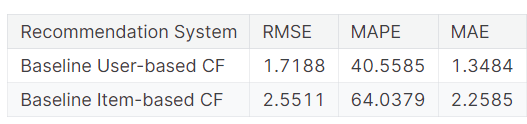